In [83]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [84]:
data = pd.read_csv('../input/honey-bee-pollen/PollenDataset/pollen_data.csv', usecols=['filename', 'pollen_carrying'])
data

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0
...,...,...
709,NP64239-233r.jpg,0
710,NP10304-132r.jpg,0
711,NP28671-238r.jpg,0
712,P14163-218r.jpg,1


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [86]:
path = '/kaggle/input/honey-bee-pollen/' / Path('P10057-125r.jpg')
path

PosixPath('/kaggle/input/honey-bee-pollen/P10057-125r.jpg')

In [87]:
'P10057-125r.jpg'

'P10057-125r.jpg'

In [88]:
def preprocess_df(df, image_path):
    df = df.copy()
    
    ### Change filename to filepath
#     print(type(df['filename'][0]))
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
#     df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
#     print(type(df['filename'][0]))

    df['pollen_carrying'] = df['pollen_carrying'].replace({1: 'POLLEN', 0: 'NO POLLEN'})

    ## train-test split
    train_df, test_df = train_test_split(df, train_size = 0.7, shuffle = True, random_state = 1)
    
    return train_df, test_df

In [89]:
train_df, test_df = preprocess_df(data, '/kaggle/input/honey-bee-pollen/PollenDataset/images')
train_df

,filename,pollen_carrying
507,/kaggle/input/honey-bee-pollen/PollenDataset/i...,POLLEN
346,/kaggle/input/honey-bee-pollen/PollenDataset/i...,NO POLLEN
160,/kaggle/input/honey-bee-pollen/PollenDataset/i...,POLLEN
463,/kaggle/input/honey-bee-pollen/PollenDataset/i...,NO POLLEN
432,/kaggle/input/honey-bee-pollen/PollenDataset/i...,POLLEN
...,...,...
144,/kaggle/input/honey-bee-pollen/PollenDataset/i...,POLLEN
645,/kaggle/input/honey-bee-pollen/PollenDataset/i...,NO POLLEN
72,/kaggle/input/honey-bee-pollen/PollenDataset/i...,POLLEN
235,/kaggle/input/honey-bee-pollen/PollenDataset/i...,NO POLLEN


In [90]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [91]:
###Creating Generator

In [92]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [93]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True, 
    seed = 42, 
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True, 
    seed = 42, 
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filename',
    y_col = 'pollen_carrying',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False, 
#     seed = 42
)

Found 400 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


In [97]:
inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
       
        )
    ]
)

2022-12-14 04:24:12.345389: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
13/13 [==============================] - 6s 413ms/step - loss: 0.6943 - accuracy: 0.4875 - val_loss: 0.6943 - val_accuracy: 0.4545
Epoch 2/100
13/13 [==============================] - 4s 272ms/step - loss: 0.6919 - accuracy: 0.5275 - val_loss: 0.6953 - val_accuracy: 0.4545
Epoch 3/100
13/13 [==============================] - 4s 276ms/step - loss: 0.6907 - accuracy: 0.5275 - val_loss: 0.6963 - val_accuracy: 0.4545
Epoch 4/100
13/13 [==============================] - 4s 271ms/step - loss: 0.6898 - accuracy: 0.5275 - val_loss: 0.6992 - val_accuracy: 0.4545
Epoch 5/100
13/13 [==============================] - 4s 281ms/step - loss: 0.6879 - accuracy: 0.5275 - val_loss: 0.6902 - val_accuracy: 0.4545
Epoch 6/100
13/13 [==============================] - 4s 300ms/step - loss: 0.6831 - accuracy: 0.5850 - val_loss: 0.6794 - val_accuracy: 0.7475
Epoch 7/100
13/13 [==============================] - 4s 276ms/step - loss: 0.6840 - accuracy: 0.5600 - val_loss: 0.6723 - val_accuracy: 0.5455

Accuracy: 86.51%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


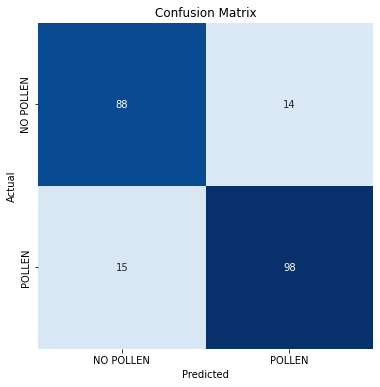

Classification Report:
----------------------
               precision    recall  f1-score   support

   NO POLLEN       0.85      0.86      0.86       102
      POLLEN       0.88      0.87      0.87       113

    accuracy                           0.87       215
   macro avg       0.86      0.87      0.86       215
weighted avg       0.87      0.87      0.87       215



In [98]:
results = model.evaluate(test_images, verbose=0)
print("Accuracy: {:.2f}%".format(results[1] * 100))

predictions = np.squeeze(model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["NO POLLEN", "POLLEN"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["NO POLLEN", "POLLEN"])
plt.yticks(ticks=[0.5, 1.5], labels=["NO POLLEN", "POLLEN"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

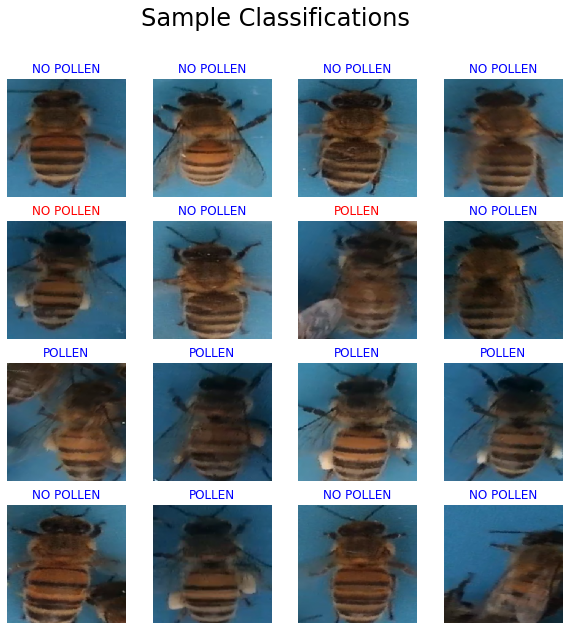

In [99]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[0][0][i])
    plt.title(
        "NO POLLEN" if predictions[i] == 0 else "POLLEN",
        color='blue' if predictions[i] == test_images.labels[i] else 'red'
    )
    plt.axis('off')

plt.suptitle("Sample Classifications", size=24)
plt.show()